In [23]:
#import libraries
import json, zstandard as zstd, pandas as pd, numpy as np, requests, io, os, re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [24]:
#import dataset 1
zst_path = "./glbx-mdp3-20201009-20251008.ohlcv-1d.csv.zst"

with open(zst_path, "rb") as fh:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(fh) as reader:
        df1 = pd.read_csv(reader, encoding="utf-8", parse_dates=["ts_event"])

df1.head()

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2020-10-09 00:00:00+00:00,35,1,178892,-0.0097,-0.0093,-0.0101,-0.0096,439,HOJ1-HOK1
1,2020-10-09 00:00:00+00:00,35,1,112388,-0.0800,-0.0700,-0.0800,-0.0700,10,CLG2-CLJ2
2,2020-10-09 00:00:00+00:00,35,1,93394,-0.0800,-0.0600,-0.1100,-0.0800,961,CLZ1-CLH2
3,2020-10-09 00:00:00+00:00,35,1,4135,-3.8600,-3.8600,-3.8600,-3.8600,1,CLZ0-BZM1
4,2020-10-09 00:00:00+00:00,35,1,180969,-0.0135,-0.0132,-0.0151,-0.0135,577,RBJ1-RBK1


In [37]:
#import dataset 2
zst_path = "./glbx-mdp3-20201018-20251017.ohlcv-1d.csv.zst"

with open(zst_path, "rb") as fh:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(fh) as reader:
        df2 = pd.read_csv(reader, encoding="utf-8", parse_dates=["ts_event"])

df2.head()

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2020-10-18 00:00:00+00:00,35,1,188775,24.290,24.365,24.250,24.330,1147,SIZ0
1,2020-10-18 00:00:00+00:00,35,1,6466,1912.700,1912.700,1912.000,1912.000,2,GCG1
2,2020-10-18 00:00:00+00:00,35,1,53777,-5.600,-5.600,-5.600,-5.600,2,GCV0-GCZ0
3,2020-10-18 00:00:00+00:00,35,1,14211,-4.000,-3.900,-4.100,-4.000,7,GCX0-GCZ0
4,2020-10-18 00:00:00+00:00,35,1,47843,-0.163,-0.162,-0.163,-0.162,56,SIZ0-SIH1


In [26]:
# combine the two dataframes
df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(by='ts_event').reset_index(drop=True)

df.head()

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2020-10-09 00:00:00+00:00,35,1,178892,-0.0097,-0.0093,-0.0101,-0.0096,439,HOJ1-HOK1
1,2020-10-09 00:00:00+00:00,35,1,180070,-0.1576,-0.1538,-0.1587,-0.1551,28,RBG1-RBM1
2,2020-10-09 00:00:00+00:00,35,1,55983,-0.9400,-0.9200,-1.1100,-1.0400,125,CLH1-CLU1
3,2020-10-09 00:00:00+00:00,35,1,180063,-0.1527,-0.1520,-0.1528,-0.1520,5,RBG1-RBK1
4,2020-10-09 00:00:00+00:00,35,1,174915,-0.0469,-0.0432,-0.0486,-0.0441,750,HOX0-HOH1


In [27]:
#cleaning
df = df.drop(columns=['publisher_id', 'rtype'])
df['ts_event'] = df['ts_event'].dt.date          
df = df.rename(columns={'ts_event': 'date'})
df['date'] = pd.to_datetime(df['date'])
## df = df[df['date'].dt.to_period('M') != '2025-04'] # to remove liberation day data but lets leave it in first
print(len(df))
df.head()

615164


,date,instrument_id,open,high,low,close,volume,symbol
0,2020-10-09,178892,-0.0097,-0.0093,-0.0101,-0.0096,439,HOJ1-HOK1
1,2020-10-09,180070,-0.1576,-0.1538,-0.1587,-0.1551,28,RBG1-RBM1
2,2020-10-09,55983,-0.9400,-0.9200,-1.1100,-1.0400,125,CLH1-CLU1
3,2020-10-09,180063,-0.1527,-0.1520,-0.1528,-0.1520,5,RBG1-RBK1
4,2020-10-09,174915,-0.0469,-0.0432,-0.0486,-0.0441,750,HOX0-HOH1


In [28]:
#displaying available products using regex
products = sorted(set(
    re.match(r'^([A-Z]{2,3})[FGHJKMNQUVXZ]\d-\1[FGHJKMNQUVXZ]\d$', s).group(1)
    for s in df['symbol'].dropna().unique()
    if re.match(r'^([A-Z]{2,3})[FGHJKMNQUVXZ]\d-\1[FGHJKMNQUVXZ]\d$', s)
))

products

['CL', 'CSX', 'GC', 'HO', 'RB', 'SI']

In [29]:
print(f"There are {df[df['symbol'].str.contains(r'^CL', case=False, na=False)].shape[0]} rows where symbol contains 'CL'.")
print(f"There are {df[df['symbol'].str.contains(r'^CSX', case=False, na=False)].shape[0]} rows where symbol contains 'CSX'.")
print(f"There are {df[df['symbol'].str.contains(r'^GC', case=False, na=False)].shape[0]} rows where symbol contains 'GC'.")
print(f"There are {df[df['symbol'].str.contains(r'^HO', case=False, na=False)].shape[0]} rows where symbol contains 'HO'.")
print(f"There are {df[df['symbol'].str.contains(r'^RB', case=False, na=False)].shape[0]} rows where symbol contains 'RB'.")
print(f"There are {df[df['symbol'].str.contains(r'^SI', case=False, na=False)].shape[0]} rows where symbol contains 'SI'.")


There are 288776 rows where symbol contains 'CL'.
There are 10 rows where symbol contains 'CSX'.
There are 42192 rows where symbol contains 'GC'.
There are 135804 rows where symbol contains 'HO'.
There are 117185 rows where symbol contains 'RB'.
There are 31196 rows where symbol contains 'SI'.


**Contract Specs**

CME Globex: CL

Trading terminates 3 business day before the 25th calendar day of the month prior to the contract month. If the 25th calendar day is not a business day, trading terminates 4 business days before the 25th calendar day of the month prior to the contract month.


CME Globex: CSX

Trading terminates on the last business day of the contract month.


CME Globex: GC

Trading terminates at 12:30 p.m. CT on the third last business day of the contract month.


CME Globex: HO

Trading terminates on the last business day of the month prior to the contract month.

	
CME Globex: RB

Trading terminates on the last business day of the month prior to the contract month.

	
CME Globex: SI

Trading terminates at 12:25 p.m. CT on the third last business day of the contract month.

In [30]:
# CME month code map
month_map = {
    "F": 1, "G": 2, "H": 3, "J": 4, "K": 5, "M": 6,
    "N": 7, "Q": 8, "U": 9, "V": 10, "X": 11, "Z": 12
}

def parse_expiry(symbol: str, prefix: str) -> pd.Timestamp | None:
    if not symbol.startswith(prefix):
        return None
    suffix = symbol[len(prefix):]
    if len(suffix) < 2:
        return None

    month_code, year_digit = suffix[0], suffix[1]
    if month_code not in month_map or not year_digit.isdigit():
        return None

    year = 2020 + int(year_digit)
    month = month_map[month_code]
    return pd.Timestamp(year, month, 1)


def filter_symbol(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    def is_valid_spread(symbol):
        parts = symbol.split('-')
        return (
            len(parts) == 2
            and all(p.startswith(prefix) for p in parts)
        )

    mask = df['symbol'].apply(is_valid_spread)
    filtered = df[mask].copy()
    filtered.reset_index(drop=True, inplace=True)
    return filtered


def classify_spread(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    df = df.copy()
    df[['front_leg', 'back_leg']] = df['symbol'].str.split('-', expand=True)

    df['front_exp'] = df['front_leg'].apply(lambda s: parse_expiry(s, prefix))
    df['back_exp']  = df['back_leg'].apply(lambda s: parse_expiry(s, prefix))

    df = df.dropna(subset=['front_exp', 'back_exp'])

    spread_labels = []
    for trade_date, group in df.groupby('date'):
        expiries = sorted(group['front_exp'].unique())
        exp_rank = {exp: i for i, exp in enumerate(expiries)}
        for _, row in group.iterrows():
            i = exp_rank.get(row['front_exp'])
            j = exp_rank.get(row['back_exp'])
            label = f"M{i}-M{j}" if i is not None and j is not None else None
            spread_labels.append(label)

    df['spread_label'] = spread_labels
    return df


def process_symbol_spread(df: pd.DataFrame, prefix: str) -> dict:
    filtered = filter_symbol(df, prefix)
    if filtered.empty:
        return {}
    labeled = classify_spread(filtered, prefix)
    return {label: grp.copy() for label, grp in labeled.groupby('spread_label')}


def process_symbol_outright(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    mask = (
        df['symbol'].str.startswith(prefix, na=False)
        & ~df['symbol'].str.contains('-', na=False)
    )
    outright = df[mask].copy()
    outright.reset_index(drop=True, inplace=True)

    outright['expiry'] = outright['symbol'].apply(lambda s: parse_expiry(s, prefix))
    outright = outright.dropna(subset=['expiry'])

    outright = (
        outright.sort_values(['date', 'expiry'])
                 .assign(month_label=lambda x:
                     x.groupby('date').cumcount().apply(lambda i: f"M{i}")
                 )
    )

    return outright


def process_symbol(df: pd.DataFrame, prefix: str) -> tuple[dict, pd.DataFrame]:
    spreads = process_symbol_spread(df, prefix)
    outrights = process_symbol_outright(df, prefix)
    return spreads, outrights


def plot_spread(spread_df: pd.DataFrame, title: str | None = None):
    if spread_df.empty:
        print("⚠️ No data to plot.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(spread_df['date'], spread_df['close'], marker='.', linewidth=1.5)
    plt.title(title or spread_df['spread_label'].iloc[0])
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [31]:
CL_spreads, CL_outright = process_symbol(df, 'CL')

CL_M0_M1 = CL_spreads['M0-M1']
CL_M1_M2 = CL_spreads['M1-M2']
CL_M2_M3 = CL_spreads['M2-M3']

In [32]:
CL_M0_M1.head(50)

,date,instrument_id,open,high,low,close,volume,symbol,front_leg,back_leg,front_exp,back_exp,spread_label
121,2020-10-09,194527,-0.28,-0.27,-0.31,-0.30,65372,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
199,2020-10-11,194527,-0.31,-0.30,-0.31,-0.31,625,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
323,2020-10-12,194527,-0.31,-0.28,-0.32,-0.29,59945,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
372,2020-10-13,194527,-0.30,-0.25,-0.30,-0.28,106376,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
504,2020-10-14,194527,-0.28,-0.26,-0.30,-0.28,98754,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
723,2020-10-15,194527,-0.27,-0.26,-0.30,-0.27,42646,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
799,2020-10-16,194527,-0.27,-0.23,-0.27,-0.23,36651,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
866,2020-10-18,194527,-0.24,-0.23,-0.25,-0.24,631,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
948,2020-10-19,194527,-0.25,-0.21,-0.25,-0.22,39543,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1
1093,2020-10-20,194527,-0.22,-0.18,-0.24,-0.20,14318,CLX0-CLZ0,CLX0,CLZ0,2020-11-01,2020-12-01,M0-M1


In [33]:
CL_outright.head(50)

,date,instrument_id,open,high,low,close,volume,symbol,expiry,month_label
13,2020-10-09,235940,41.22,41.40,40.38,40.52,210592,CLX0,2020-11-01,M0
9,2020-10-09,207193,41.50,41.67,40.68,40.85,47474,CLZ0,2020-12-01,M1
12,2020-10-09,66414,41.82,42.01,41.04,41.21,8473,CLF1,2021-01-01,M2
10,2020-10-09,362120,42.10,42.31,41.37,41.53,2176,CLG1,2021-02-01,M3
18,2020-10-09,169953,42.41,42.58,41.69,41.83,2812,CLH1,2021-03-01,M4
20,2020-10-09,746868,42.62,42.80,41.93,42.15,659,CLJ1,2021-04-01,M5
3,2020-10-09,554496,42.80,43.01,42.15,42.29,856,CLK1,2021-05-01,M6
4,2020-10-09,253895,43.04,43.21,42.33,42.50,6846,CLM1,2021-06-01,M7
8,2020-10-09,492615,43.09,43.31,42.53,42.66,684,CLN1,2021-07-01,M8
0,2020-10-09,300251,43.18,43.34,42.74,42.80,61,CLQ1,2021-08-01,M9


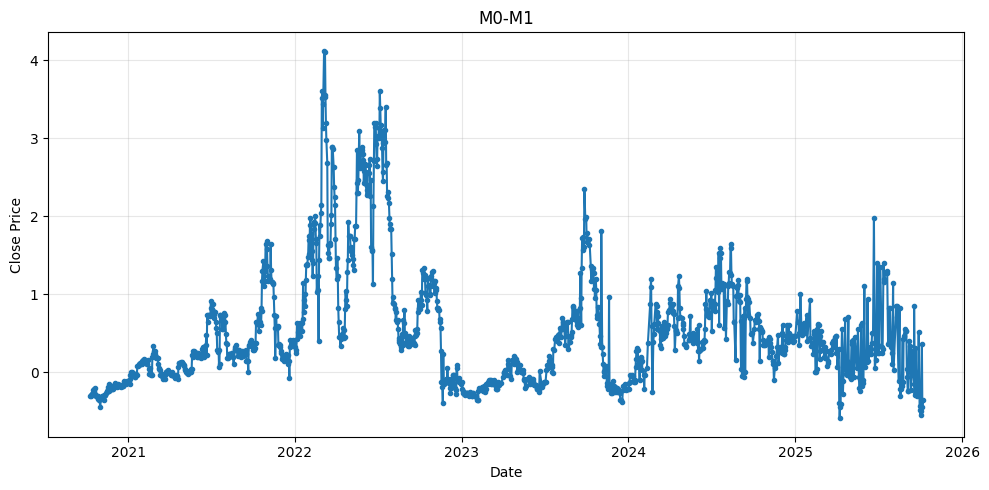

In [34]:
plot_spread(CL_M0_M1)